#**LUNAR_Improvement**
Files: https://drive.google.com/drive/folders/1SD1qmuH-5BdNVOEtOXN-gq3aXlTHYz7E?usp=drive_link

Paper: https://arxiv.org/pdf/2112.05355.pdf

Code & Data: https://github.com/agoodge/LUNAR

## Target

Tasks1:

1. decreasing performance by training on noisy data: add a proportion P% of anomalies into the training set (change P%=10%,30%,50%)

2. decreasing performance by reduce the number of training data: reduce the number of normal samples in the training set (change to 50%, 70%, 90% of the original normal samples)

3. random subsetting the features => K feature subsets cover all features (e.g., K=3,6,9), then construct K LUNAR models => average the scores of K models to be final outcome

Tasks2:

###專題主旨 : 如何設計Subset? 兩個方向：( 1 ) 選擇 subset    ( 2 ) subset的KNN的k

1. 減少train的數量(可以建Graph但不能用來train), 用在3-1的上面來做

2. 確認layer的層數, 試LUNAR本身加成2個layer的GNN
  原：歐式距離來算
  第二層：歐式距離 做neighbor aggregation or 用embedding重新建一個Graph(一樣做歐式距離)

3. 用Feature的相關性來分subsets
  Ex. HRSS的20個feature做分群(分成3群)

  每一群當成一個subsets, (允許overlap?)
  20 * 90000
  -> 90000 * 20

  用90000維的feature做k-means,
  設定為3 6 9 群，
  變成3 6 9個subsets(利用feature的相似度)

4. Think : 有沒有合理的方式評估不同subset的k要設定多少?

  一、因為k會影響Graph密度 -> 從小的dataset觀察, 把graph畫出來看多少個neighbor適合

  二、算出距離, 距離norm成0 - 1, 用0.1內的neighbor(每個node用的k都不一樣)

  三、直接爆train看看



## Result

###Target 1 & 2


![](https://drive.google.com/uc?export=view&id=101bgQYb8hFgw-JWR4pbr9mj8FLVS2drt)



###Target 3



![](https://drive.google.com/uc?export=view&id=1J9DrE2bOoFohEDLbeG0NXV13soYomocF)


###Experiment Records


1. Target 1 & 2

  https://drive.google.com/file/d/1jtsUIPh61C0M4giwCyIUv_d9vdjbJzUO/view?usp=drive_link
2. Target 3 - Testing Overlap percentage

  https://drive.google.com/file/d/1m1LK0eslL-ngXRhGUK_ykyLVfOtGpSMC/view?usp=drive_link
3. Target 3 - Summary

  https://drive.google.com/file/d/1tkIBHew8PANg5l-7WubTQEM9PAzd6hHY/view?usp=drive_link

## 前置作業

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_folder = '/content/drive/MyDrive/LUNAR'
os.chdir(project_folder)
import torch
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0%2Bcu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0%2Bcu121.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install faiss-gpu

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 35.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 2.2 MB/s eta 0:00:00


#Task 1 Code


### Import libraries

In [ ]:
import time
import faiss
import argparse
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing

## 程式碼

### variables.py

In [ ]:
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model parameters for gnn
n_epochs = 200
lr = 0.001
wd = 0.1

# negative sample hyperparameters
epsilon = 0.1
proportion = 1

### utils.py

NEGATIVE SAMPLE FUNCTIONS

In [ ]:
def negative_samples(train_x, train_y, val_x, val_y, test_x, test_y, k, sample_type, proportion, epsilon):

    # training set negative samples
    neg_train_x, neg_train_y = generate_negative_samples(train_x, sample_type, proportion, epsilon)
    # validation set negative samples
    neg_val_x, neg_val_y = generate_negative_samples(val_x, sample_type, proportion, epsilon)

    # concat data
    x = np.vstack((train_x,neg_train_x,val_x,neg_val_x,test_x))
    y = np.hstack((train_y,neg_train_y,val_y,neg_val_y,test_y))

    # all training set
    train_mask = np.hstack((np.ones(len(train_x)),np.ones(len(neg_train_x)),
                            np.zeros(len(val_x)),np.zeros(len(neg_val_x)),
                            np.zeros(len(test_x))))
    # all validation set
    val_mask = np.hstack((np.zeros(len(train_x)),np.zeros(len(neg_train_x)),
                          np.ones(len(val_x)),np.ones(len(neg_val_x)),
                          np.zeros(len(test_x))))
    # all test set
    test_mask = np.hstack((np.zeros(len(train_x)),np.zeros(len(neg_train_x)),
                           np.zeros(len(val_x)),np.zeros(len(neg_val_x)),
                           np.ones(len(test_x))))
    # normal training points
    neighbor_mask = np.hstack((np.ones(len(train_x)), np.zeros(len(neg_train_x)),
                               np.zeros(len(val_y)), np.zeros(len(neg_val_x)),
                               np.zeros(len(test_y))))

    # find k nearest neighbours (idx) and their distances (dist) to each points in x within neighbour_mask==1
    dist, idx = find_neighbors(x, y, neighbor_mask, k)

    return x.astype('float32'), y.astype('float32'), neighbor_mask.astype('float32'), train_mask.astype('float32'), val_mask.astype('float32'), test_mask.astype('float32'), dist, idx

# loading negative samples
def generate_negative_samples(x, sample_type, proportion, epsilon):

    n_samples = int(proportion*(len(x)))
    n_dim = x.shape[-1]

    #M
    randmat = np.random.rand(n_samples,n_dim) < 0.3
    # uniform samples
    rand_unif = (epsilon* (1-2*np.random.rand(n_samples,n_dim)))
    #  subspace perturbation samples
    rand_sub = np.tile(x, (proportion,1)) + randmat*(epsilon*np.random.randn(n_samples,n_dim))

    if sample_type == 'UNIFORM':
        neg_x = rand_unif
    if sample_type == 'SUBSPACE':
        neg_x = rand_sub
    if sample_type == 'MIXED':
        # randomly sample from uniform and gaussian negative samples
        neg_x = np.concatenate((rand_unif, rand_sub),0)
        neg_x = neg_x[np.random.choice(np.arange(len(neg_x)), size = n_samples)]

    neg_y = np.ones(len(neg_x))

    return neg_x.astype('float32'), neg_y.astype('float32')

GRAPH FUNCTIONS

In [ ]:
# find the k nearest neighbours of all x points out of the neighbour candidates
def find_neighbors(x, y, neighbor_mask, k):

    # nearest neighbour object
    index = faiss.IndexFlatL2(x.shape[-1])
    # add nearest neighbour candidates
    index.add(x[neighbor_mask==1])

    # distances and idx of neighbour points for the neighbour candidates (k+1 as the first one will be the point itself)
    dist_train, idx_train = index.search(x[neighbor_mask==1], k = k+1)
    # remove 1st nearest neighbours to remove self loops
    dist_train, idx_train = dist_train[:,1:], idx_train[:,1:]
    # distances and idx of neighbour points for the non-neighbour candidates
    dist_test, idx_test = index.search(x[neighbor_mask==0], k = k)
    #concat
    dist = np.vstack((dist_train, dist_test))
    idx = np.vstack((idx_train, idx_test))

    return dist, idx

# create graph object out of x, y, distances and indices of neighbours
def build_graph(x, y, dist, idx):

    # array like [0,0,0,0,0,1,1,1,1,1,...,n,n,n,n,n] for k = 5 (i.e. edges sources)
    idx_source = np.repeat(np.arange(len(x)),dist.shape[-1]).astype('int32')
    idx_source = np.expand_dims(idx_source,axis=0)

    # edge targets, i.e. the nearest k neighbours of point 0, 1,..., n
    idx_target = idx.flatten()
    idx_target = np.expand_dims(idx_target,axis=0).astype('int32')

    #stack source and target indices
    idx = np.vstack((idx_source, idx_target))

    # edge weights
    attr = dist.flatten()
    attr = np.sqrt(attr)
    attr = np.expand_dims(attr, axis=1)

    # into tensors
    x = torch.tensor(x, dtype = torch.float32)
    y = torch.tensor(y,dtype = torch.float32)
    idx = torch.tensor(idx, dtype = torch.long)
    attr = torch.tensor(attr, dtype = torch.float32)

    #build PyTorch geometric Data object
    data = Data(x = x, edge_index = idx, edge_attr = attr, y = y)

    return data

DATASET FUNCTIONS

In [ ]:
# split training data into train set and validation set
def split_data(seed, all_train_x, all_train_y, all_test_x, all_test_y):
    np.random.seed(seed)

    val_idx = np.random.choice(np.arange(len(all_train_x)),size = int(0.15*len(all_train_x)), replace = False)
    val_mask = np.zeros(len(all_train_x))
    val_mask[val_idx] = 1
    val_x = all_train_x[val_mask == 1]; val_y = all_train_y[val_mask == 1]
    train_x = all_train_x[val_mask == 0]; train_y = all_train_y[val_mask == 0]

    scaler = MinMaxScaler()
    scaler.fit(train_x[train_y == 0])
    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)

    if all_test_x is None:
        test_x = val_x
        test_y = val_y

    test_x = scaler.transform(all_test_x)
    test_y = all_test_y

    return train_x.astype('float32'), train_y.astype('float32'), val_x.astype('float32'), val_y.astype('float32'),  test_x.astype('float32'), test_y.astype('float32')


#load data
def load_dataset(dataset,seed):
    np.random.seed(seed)

    if dataset == 'MI-V':
        df = pd.read_csv("data/MI/experiment_01.csv")
        for i in ['02','03','11','12','13','14','15','17','18']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
        normal_idx = np.ones(len(df))
        for i in ['06','08','09','10']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
            normal_idx = np.append(normal_idx,np.zeros(len(data)))
        machining_process_one_hot = pd.get_dummies(df['Machining_Process'])
        df = pd.concat([df.drop(['Machining_Process'],axis=1),machining_process_one_hot],axis=1)
        data = df.to_numpy()
        idx = np.unique(data,axis=0, return_index = True)[1]
        data = data[idx]
        normal_idx = normal_idx[idx]
        normal_data = data[normal_idx == 1]
        anomaly_data = data[normal_idx == 0]
        test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anomaly_data), replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
        train_x = normal_data[train_idx]
        train_y = np.zeros(len(train_x))
        test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
        test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))

    elif dataset == 'MI-F':
        df = pd.read_csv("data/MI/experiment_01.csv")
        for i in ['02','03','06','08','09','10','11','12','13','14','15','17','18']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
        normal_idx = np.ones(len(df))
        for i in ['04', '05', '07', '16']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
            normal_idx = np.append(normal_idx,np.zeros(len(data)))
        machining_process_one_hot = pd.get_dummies(df['Machining_Process'])
        df = pd.concat([df.drop(['Machining_Process'],axis=1),machining_process_one_hot],axis=1)
        data = df.to_numpy()
        idx = np.unique(data,axis=0, return_index = True)[1]
        data = data[idx]
        normal_idx = normal_idx[idx]
        normal_data = data[normal_idx == 1]
        anomaly_data = data[normal_idx == 0]
        test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anomaly_data), replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
        train_x = normal_data[train_idx]
        train_y = np.zeros(len(train_x))
        test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
        test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))

    elif dataset in ['OPTDIGITS', 'PENDIGITS','SHUTTLE']:
        if dataset == 'SHUTTLE':
            data = loadmat("data/SHUTTLE/shuttle.mat")
        elif dataset == 'OPTDIGITS':
            data = loadmat("data/optdigits/optdigits.mat")
        elif dataset == 'PENDIGITS':
            data = loadmat('data/PENDIGITS/pendigits.mat')
        label = data['y'].astype('float32').squeeze()
        data = data['X'].astype('float32')
        normal_data= data[label == 0]
        normal_label = label[label==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]
        test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anom_data), replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
        train_x = normal_data[train_idx]
        train_y = normal_label[train_idx]
        test_x = np.concatenate((normal_data[test_idx],anom_data))
        test_y = np.concatenate((normal_label[test_idx],anom_label))

    elif dataset in ['THYROID','HRSS']:
        if dataset == 'THYROID':
            data = pd.read_csv('data/THYROID/annthyroid_21feat_normalised.csv').to_numpy()
        if dataset == 'HRSS':
            data = pd.read_csv('data/HRSS/HRSS.csv').to_numpy()
        label = data[:,-1].astype('float32').squeeze()
        data = data[:,:-1].astype('float32')
        normal_data= data[label == 0]
        normal_label = label[label==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]
        test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anom_data), replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
        train_x = normal_data[train_idx]
        train_y = normal_label[train_idx]
        test_x = np.concatenate((normal_data[test_idx],anom_data))
        test_y = np.concatenate((normal_label[test_idx],anom_label))

    elif dataset == 'SATELLITE':
        data = loadmat('data/SATELLITE/satellite.mat')
        label = data['y'].astype('float32').squeeze()
        data = data['X'].astype('float32')
        normal_data = data[label == 0]
        normal_label = label[label ==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]
        train_idx = np.random.choice(np.arange(0,len(normal_data)), 4000, replace = False)
        test_idx = np.setdiff1d(np.arange(0,len(normal_data)), train_idx)
        train_x = normal_data[train_idx]
        train_y = normal_label[train_idx]
        test_x = normal_data[test_idx]
        test_y = normal_label[test_idx]
        test_idx = np.random.choice(np.arange(0,len(anom_data)), int(len(test_x)), replace = False)
        test_x = np.concatenate((test_x,anom_data[test_idx]))
        test_y = np.concatenate((test_y, anom_label[test_idx]))

    train_x, train_y, val_x, val_y, test_x, test_y = split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)

    return train_x, train_y, val_x, val_y, test_x, test_y

### lunar.py

In [ ]:
# Message passing scheme
class GNN1(MessagePassing):
    def __init__(self,k):
        super(GNN1, self).__init__(flow="target_to_source")
        self.k = k
        self.hidden_size = 256
        self.network = nn.Sequential(
            nn.Linear(k,self.hidden_size),
            nn.Tanh(),
            nn.Linear(self.hidden_size,self.hidden_size),
            nn.Tanh(),
            nn.Linear(self.hidden_size,self.hidden_size),
            nn.Tanh(),
            nn.Linear(self.hidden_size,1),
            nn.Sigmoid()
            )

    def forward(self, x, edge_index, edge_attr):
        self.network = self.network.to(dtype = torch.float32)
        out = self.propagate(edge_index = edge_index, x=x, edge_attr=edge_attr, k = self.k, network=self.network)
        return out

    def message(self,x_i,x_j,edge_attr):
        # message is the edge weight
        return edge_attr

    def aggregate(self, inputs, index, k, network):
        # concatenate all k messages
        self.input_aggr = inputs.reshape(-1,k)
        # pass through network
        out = self.network(self.input_aggr)
        return out

# GNN
class GNN(torch.nn.Module):
    def __init__(self, k):
        super(GNN, self).__init__()
        self.k = k
        self.L1 = GNN1(self.k)
    def forward(self,data):
        self.edge_attr = data.edge_attr
        self.edge_index = data.edge_index
        self.x = data.x
        out = self.L1(self.x, self.edge_index, self.edge_attr)
        out = torch.squeeze(out,1)
        return out

def run(train_x,train_y,val_x,val_y,test_x,test_y,dataset,seed,k,samples,train_new_model):

    # loss function
    criterion = nn.MSELoss(reduction = 'none')

    # path to save model parameters
    model_path = 'saved_models/%s/%d/net_%d.pth' %(dataset,k,seed)
    if not os.path.exists(os.path.dirname(model_path)):
       os.makedirs(os.path.dirname(model_path))

    x, y, neighbor_mask, train_mask, val_mask, test_mask, dist, idx = negative_samples(train_x, train_y, val_x, val_y, test_x, test_y, k, samples, proportion, epsilon)
    data = build_graph(x, y, dist, idx)

    data = data.to(device)
    torch.manual_seed(seed)
    net = GNN(k).to(device)

    if train_new_model == True:

        optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay = wd)

        with torch.no_grad():

            net.eval()
            out = net(data)
            loss = criterion(out,data.y)

            val_loss = loss[val_mask == 1].mean()
            val_score = roc_auc_score(data.y[val_mask==1].cpu(),out[val_mask==1].cpu())

            best_val_score = 0

        # training
        for epoch in range(n_epochs):
            net.train()
            optimizer.zero_grad()
            out = net(data)
            # loss for training data only
            loss = criterion(out[train_mask == 1],data.y[train_mask == 1]).sum()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                net.eval()
                out = net(data)
                loss = criterion(out,data.y)

                val_loss = loss[val_mask == 1].mean()
                val_score = roc_auc_score(data.y[val_mask==1].cpu(),out[val_mask==1].cpu())

                # if new model gives the best validation set score
                if val_score >= best_val_score:

                    # save model parameters
                    best_dict = {'epoch': epoch,
                           'model_state_dict': deepcopy(net.state_dict()),
                           'optimizer_state_dict': deepcopy(optimizer.state_dict()),
                           'val_loss': val_loss,
                           'val_score': val_score,
                           'k': k,}

                    # save best model
                    #torch.save(best_dict, model_path)

                    # reset best score so far
                    best_val_score = val_score

        # load best model
        net.load_state_dict(best_dict['model_state_dict'])

    # if not training a new model, load the saved model
    if train_new_model == False:

        load_dict = torch.load(model_path)
        net.load_state_dict(load_dict['model_state_dict'])

    # testing
    with torch.no_grad():
        net.eval()
        out = net(data)
        loss = criterion(out,data.y)

    # return output for test points
    return out[test_mask==1].cpu()

### main.py

In [ ]:
def main(args):
    dataset = args.dataset
    samples = args.samples
    k = args.k
    train_new_model = args.train_new_model
    mode = args.mode

    if mode == 0:
        for seed in [0,4]:
            #print("Running trial with random seed = %d" %seed)
            train_x, train_y, val_x, val_y, test_x, test_y = load_dataset(args.dataset,seed)
            start = time.time()
            test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,args.dataset,seed,args.k,args.samples,args.train_new_model)
            end = time.time()
            score = 100*roc_auc_score(test_y, test_out)
            print('Dataset: %s \t Samples: %s \t k: %d \t Score: %.4f \t Runtime: %.2f seconds' %(args.dataset,args.samples,args.k,score,(end-start)))
    elif mode == 1:
        Ps = [10, 30, 50]
        for P in Ps:
            print(f"Percentage = {P} : ")
            seed = 195
            #print("Running trial with random seed = %d" %seed)
            train_x, train_y, val_x, val_y, test_x, test_y = target1_load_dataset(args.dataset,seed, P)
            start = time.time()
            test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,args.dataset,seed,args.k,args.samples,args.train_new_model)
            end = time.time()
            score = 100*roc_auc_score(test_y, test_out)
            print('Dataset: %s \t Samples: %s \t k: %d \t Score: %.4f \t Runtime: %.2f seconds' %(args.dataset,args.samples,args.k,score,(end-start)))
    elif mode == 2:
        percentages = [50, 70, 90]
        for percentage in percentages:
            print(f"Percentage = {percentage} : ")
            seed = 3
            #print("Running trial with random seed = %d" %seed)
            train_x, train_y, val_x, val_y, test_x, test_y = target2_load_dataset(args.dataset,seed,percentage)
            start = time.time()
            test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,args.dataset,seed,args.k,args.samples,args.train_new_model)
            end = time.time()
            score = 100*roc_auc_score(test_y, test_out)
            print('Dataset: %s \t Samples: %s \t k: %d \t Score: %.4f \t Runtime: %.2f seconds' %(args.dataset,args.samples,args.k,score,(end-start)))



## Experiment

### Target 1
Decreasing performance by training on noisy data: add a proportion P% of anomalies into the training set (change P%=10%,30%,50%)

In [ ]:
def target1_split_data(seed, all_train_x, all_train_y, all_test_x, all_test_y):
    np.random.seed(seed)

    val_idx = np.random.choice(np.arange(len(all_train_x)),size = int(0.15*len(all_train_x)), replace = False)
    val_mask = np.zeros(len(all_train_x))
    val_mask[val_idx] = 1
    val_x = all_train_x[val_mask == 1]; val_y = all_train_y[val_mask == 1]
    train_x = all_train_x[val_mask == 0]; train_y = all_train_y[val_mask == 0]

    scaler = MinMaxScaler()
    scaler.fit(train_x[train_y == 0])
    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)

    if all_test_x is None:
        test_x = val_x
        test_y = val_y

    test_x = scaler.transform(all_test_x)
    test_y = all_test_y

    return train_x.astype('float32'), train_y.astype('float32'), val_x.astype('float32'), val_y.astype('float32'),  test_x.astype('float32'), test_y.astype('float32')


#load data
def target1_load_dataset(dataset,seed, P):
    np.random.seed(seed)

    if dataset == 'MI-V':
        df = pd.read_csv("data/MI/experiment_01.csv")
        for i in ['02','03','11','12','13','14','15','17','18']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
        normal_idx = np.ones(len(df))
        for i in ['06','08','09','10']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
            normal_idx = np.append(normal_idx,np.zeros(len(data)))
        machining_process_one_hot = pd.get_dummies(df['Machining_Process'])
        df = pd.concat([df.drop(['Machining_Process'],axis=1),machining_process_one_hot],axis=1)
        data = df.to_numpy()
        idx = np.unique(data,axis=0, return_index = True)[1]
        data = data[idx]
        normal_idx = normal_idx[idx]
        normal_data = data[normal_idx == 1]
        anomaly_data = data[normal_idx == 0]

        num_anomalies_to_add = int(len(anomaly_data) * P / 100)
        num_anomalies_remain = len(anomaly_data) - num_anomalies_to_add
        anomaly_idx_to_add = np.random.choice(np.arange(0, len(anomaly_data)), num_anomalies_to_add, replace=False)
        remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anomaly_data)), anomaly_idx_to_add)

        test_idx = np.random.choice(np.arange(0,len(normal_data)), num_anomalies_remain, replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
        train_x = np.concatenate((normal_data[train_idx], anomaly_data[anomaly_idx_to_add]))
        train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
        test_x = np.concatenate((anomaly_data[remaining_anomaly_idx], normal_data[test_idx]))
        test_y  = np.concatenate((np.ones(len(remaining_anomaly_idx)), np.zeros(len(test_idx))))

        #train_x = normal_data[train_idx]
        #train_y = np.zeros(len(train_x))
        #test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
        #test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))

    elif dataset == 'MI-F':
        df = pd.read_csv("data/MI/experiment_01.csv")
        for i in ['02','03','06','08','09','10','11','12','13','14','15','17','18']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
        normal_idx = np.ones(len(df))
        for i in ['04', '05', '07', '16']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
            normal_idx = np.append(normal_idx,np.zeros(len(data)))
        machining_process_one_hot = pd.get_dummies(df['Machining_Process'])
        df = pd.concat([df.drop(['Machining_Process'],axis=1),machining_process_one_hot],axis=1)
        data = df.to_numpy()
        idx = np.unique(data,axis=0, return_index = True)[1]
        data = data[idx]
        normal_idx = normal_idx[idx]
        normal_data = data[normal_idx == 1]
        anomaly_data = data[normal_idx == 0]

        num_anomalies_to_add = int(len(anomaly_data) * P / 100)
        num_anomalies_remain = len(anomaly_data) - num_anomalies_to_add
        anomaly_idx_to_add = np.random.choice(np.arange(0, len(anomaly_data)), num_anomalies_to_add, replace=False)
        remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anomaly_data)), anomaly_idx_to_add)

        test_idx = np.random.choice(np.arange(0,len(normal_data)), num_anomalies_remain, replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
        train_x = np.concatenate((normal_data[train_idx], anomaly_data[anomaly_idx_to_add]))
        train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
        test_x = np.concatenate((anomaly_data[remaining_anomaly_idx], normal_data[test_idx]))
        test_y  = np.concatenate((np.ones(len(remaining_anomaly_idx)), np.zeros(len(test_idx))))

        #train_x = normal_data[train_idx]
        #train_y = np.zeros(len(train_x))
        #test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
        #test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))

    elif dataset in ['OPTDIGITS', 'PENDIGITS','SHUTTLE']:
        if dataset == 'SHUTTLE':
            data = loadmat("data/SHUTTLE/shuttle.mat")
        elif dataset == 'OPTDIGITS':
            data = loadmat("data/optdigits/optdigits.mat")
        elif dataset == 'PENDIGITS':
            data = loadmat('data/PENDIGITS/pendigits.mat')
        label = data['y'].astype('float32').squeeze()
        data = data['X'].astype('float32')
        normal_data= data[label == 0]
        normal_label = label[label==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]

        num_anomalies_to_add = int(len(anom_data) * P / 100)
        num_anomalies_remain = len(anom_data) - num_anomalies_to_add
        anomaly_idx_to_add = np.random.choice(np.arange(0, len(anom_data)), num_anomalies_to_add, replace=False)
        remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anom_data)), anomaly_idx_to_add)

        test_idx = np.random.choice(np.arange(0,len(normal_data)), num_anomalies_remain, replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
        train_x = np.concatenate((normal_data[train_idx], anom_data[anomaly_idx_to_add]))
        train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
        test_x = np.concatenate((anom_data[remaining_anomaly_idx], normal_data[test_idx]))
        test_y  = np.concatenate((np.ones(len(remaining_anomaly_idx)), np.zeros(len(test_idx))))

        #train_x = normal_data[train_idx]
        #train_y = normal_label[train_idx]
        #test_x = np.concatenate((normal_data[test_idx],anom_data))
        #test_y = np.concatenate((normal_label[test_idx],anom_label))

    elif dataset in ['THYROID','HRSS']:
        if dataset == 'THYROID':
            data = pd.read_csv('data/THYROID/annthyroid_21feat_normalised.csv').to_numpy()
        if dataset == 'HRSS':
            data = pd.read_csv('data/HRSS/HRSS.csv').to_numpy()
        label = data[:,-1].astype('float32').squeeze()
        data = data[:,:-1].astype('float32')
        normal_data= data[label == 0]
        normal_label = label[label==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]

        num_anomalies_to_add = int(len(anom_data) * P / 100)
        num_anomalies_remain = len(anom_data) - num_anomalies_to_add
        anomaly_idx_to_add = np.random.choice(np.arange(0, len(anom_data)), num_anomalies_to_add, replace=False)
        remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anom_data)), anomaly_idx_to_add)

        test_idx = np.random.choice(np.arange(0,len(normal_data)), num_anomalies_remain, replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
        train_x = np.concatenate((normal_data[train_idx], anom_data[anomaly_idx_to_add]))
        train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
        test_x = np.concatenate((anom_data[remaining_anomaly_idx], normal_data[test_idx]))
        test_y  = np.concatenate((np.ones(len(remaining_anomaly_idx)), np.zeros(len(test_idx))))

        #train_x = normal_data[train_idx]
        #train_y = normal_label[train_idx]
        #test_x = np.concatenate((normal_data[test_idx],anom_data))
        #test_y = np.concatenate((normal_label[test_idx],anom_label))

    elif dataset == 'SATELLITE':
        data = loadmat('data/SATELLITE/satellite.mat')
        label = data['y'].astype('float32').squeeze()
        data = data['X'].astype('float32')
        normal_data = data[label == 0]
        normal_label = label[label ==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]

        num_anomalies_to_add = int(len(anom_data) * P / 100)
        num_anomalies_remain = len(anom_data) - num_anomalies_to_add
        anomaly_idx_to_add = np.random.choice(np.arange(0, len(anom_data)), num_anomalies_to_add, replace=False)
        remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anom_data)), anomaly_idx_to_add)

        train_idx = np.random.choice(np.arange(0,len(normal_data)), 4000, replace = False)
        test_idx = np.setdiff1d(np.arange(0,len(normal_data)), train_idx)

        train_x = np.concatenate((normal_data[train_idx], anom_data[anomaly_idx_to_add]))
        train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
        test_x = normal_data[test_idx]
        test_y  = normal_label[test_idx]

        selected_anomaly_idx = np.random.choice(remaining_anomaly_idx, len(test_x), replace=False)
        test_x = np.concatenate((test_x, anom_data[selected_anomaly_idx]))
        test_y = np.concatenate((test_y, anom_label[selected_anomaly_idx]))

        #train_idx = np.random.choice(np.arange(0,len(normal_data)), 4000, replace = False)
        #test_idx = np.setdiff1d(np.arange(0,len(normal_data)), train_idx)
        #train_x = normal_data[train_idx]
        #train_y = normal_label[train_idx]
        #test_x = normal_data[test_idx]
        #test_y = normal_label[test_idx]
        #test_idx = np.random.choice(np.arange(0,len(anom_data)), int(len(test_x)), replace = False)
        #test_x = np.concatenate((test_x,anom_data[test_idx]))
        #test_y = np.concatenate((test_y, anom_label[test_idx]))

    train_x, train_y, val_x, val_y, test_x, test_y = target1_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)

    return train_x, train_y, val_x, val_y, test_x, test_y

### Target 2
decreasing performance by reduce the number of training data: reduce the number of normal samples in the training set (change to 50%, 70%, 90% of the original normal samples)


In [ ]:
def reduce_normal_samples(normal_data, percentage):
    # Calculate the number of normal samples to keep based on the percentage
    num_samples_to_keep = int(len(normal_data) * percentage / 100)
    # Randomly select
    idx_to_keep = np.random.choice(np.arange(0, len(normal_data)), num_samples_to_keep, replace=False)
    return normal_data[idx_to_keep]

In [ ]:
def target2_split_data(seed, all_train_x, all_train_y, all_test_x, all_test_y):
    np.random.seed(seed)

    val_idx = np.random.choice(np.arange(len(all_train_x)), size=int(0.15 * len(all_train_x)), replace=False)
    val_mask = np.zeros(len(all_train_x), dtype=bool)
    val_mask[val_idx] = True

    # Use np.where to split data based on the boolean mask
    val_x, val_y = all_train_x[np.where(val_mask)], all_train_y[np.where(val_mask)]
    train_x, train_y = all_train_x[np.where(~val_mask)], all_train_y[np.where(~val_mask)]

    scaler = MinMaxScaler()
    scaler.fit(train_x[train_y == 0])
    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)

    if all_test_x is None:
        test_x = val_x
        test_y = val_y
    else:
        test_x = scaler.transform(all_test_x)
        test_y = all_test_y

    return (
        train_x.astype('float32'), train_y.astype('float32'),
        val_x.astype('float32'), val_y.astype('float32'),
        test_x.astype('float32'), test_y.astype('float32')
    )

In [ ]:
def target2_load_dataset(dataset,seed,percentage):
    np.random.seed(seed)

    if dataset == 'MI-V':
        df = pd.read_csv("data/MI/experiment_01.csv")
        for i in ['02','03','11','12','13','14','15','17','18']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
        normal_idx = np.ones(len(df))
        for i in ['06','08','09','10']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
            normal_idx = np.append(normal_idx,np.zeros(len(data)))
        machining_process_one_hot = pd.get_dummies(df['Machining_Process'])
        df = pd.concat([df.drop(['Machining_Process'],axis=1),machining_process_one_hot],axis=1)
        data = df.to_numpy()
        idx = np.unique(data,axis=0, return_index = True)[1]
        data = data[idx]
        normal_idx = normal_idx[idx]
        normal_data = data[normal_idx == 1]
        anomaly_data = data[normal_idx == 0]
        test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anomaly_data), replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)

        train_x = reduce_normal_samples(normal_data[train_idx], percentage)
        #train_x = normal_data[train_idx]
        train_y = np.zeros(len(train_x))

        test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
        test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))

    elif dataset == 'MI-F':
        df = pd.read_csv("data/MI/experiment_01.csv")
        for i in ['02','03','06','08','09','10','11','12','13','14','15','17','18']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
        normal_idx = np.ones(len(df))
        for i in ['04', '05', '07', '16']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
            normal_idx = np.append(normal_idx,np.zeros(len(data)))
        machining_process_one_hot = pd.get_dummies(df['Machining_Process'])
        df = pd.concat([df.drop(['Machining_Process'],axis=1),machining_process_one_hot],axis=1)
        data = df.to_numpy()
        idx = np.unique(data,axis=0, return_index = True)[1]
        data = data[idx]
        normal_idx = normal_idx[idx]
        normal_data = data[normal_idx == 1]
        anomaly_data = data[normal_idx == 0]
        test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anomaly_data), replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)

        train_x = reduce_normal_samples(normal_data[train_idx], percentage)
        #train_x = normal_data[train_idx]
        train_y = np.zeros(len(train_x))

        test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
        test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))

    elif dataset in ['OPTDIGITS', 'PENDIGITS','SHUTTLE']:
        if dataset == 'SHUTTLE':
            data = loadmat("data/SHUTTLE/shuttle.mat")
        elif dataset == 'OPTDIGITS':
            data = loadmat("data/optdigits/optdigits.mat")
        elif dataset == 'PENDIGITS':
            data = loadmat('data/PENDIGITS/pendigits.mat')
        label = data['y'].astype('float32').squeeze()
        data = data['X'].astype('float32')
        normal_data= data[label == 0]
        normal_label = label[label==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]
        test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anom_data), replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)

        train_x = reduce_normal_samples(normal_data[train_idx], percentage)
        #train_x = normal_data[train_idx]
        train_y = normal_label[train_idx]

        test_x = np.concatenate((normal_data[test_idx],anom_data))
        test_y = np.concatenate((normal_label[test_idx],anom_label))

    elif dataset in ['THYROID','HRSS']:
        if dataset == 'THYROID':
            data = pd.read_csv('data/THYROID/annthyroid_21feat_normalised.csv').to_numpy()
        if dataset == 'HRSS':
            data = pd.read_csv('data/HRSS/HRSS.csv').to_numpy()
        label = data[:,-1].astype('float32').squeeze()
        data = data[:,:-1].astype('float32')
        normal_data= data[label == 0]
        normal_label = label[label==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]
        test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anom_data), replace = False)
        train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)

        train_x = reduce_normal_samples(normal_data[train_idx], percentage)
        #train_x = normal_data[train_idx]
        train_y = normal_label[train_idx]

        test_x = np.concatenate((normal_data[test_idx],anom_data))
        test_y = np.concatenate((normal_label[test_idx],anom_label))

    elif dataset == 'SATELLITE':
        data = loadmat('data/SATELLITE/satellite.mat')
        label = data['y'].astype('float32').squeeze()
        data = data['X'].astype('float32')
        normal_data = data[label == 0]
        normal_label = label[label ==0]
        anom_data = data[label == 1]
        anom_label = label[label ==1]
        train_idx = np.random.choice(np.arange(0,len(normal_data)), 4000, replace = False)
        test_idx = np.setdiff1d(np.arange(0,len(normal_data)), train_idx)

        train_x = reduce_normal_samples(normal_data[train_idx], percentage)
        #train_x = normal_data[train_idx]
        train_y = normal_label[train_idx]

        test_x = normal_data[test_idx]
        test_y = normal_label[test_idx]
        test_idx = np.random.choice(np.arange(0,len(anom_data)), int(len(test_x)), replace = False)
        test_x = np.concatenate((test_x,anom_data[test_idx]))
        test_y = np.concatenate((test_y, anom_label[test_idx]))

    train_x, train_y, val_x, val_y, test_x, test_y = target2_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)

    return train_x, train_y, val_x, val_y, test_x, test_y

### Target 3
random subsetting the features => K feature subsets cover all features (e.g., K=3,6,9), then construct K LUNAR models => average the scores of K models to be final outcome

HRSS : 20 | MI-F : 58 | MI-V : 58 | OPTDIGITS : 64  
PENDIGITS : 16 | SATELLITE : 36 | SHUTTLE : 9 | THYROIDm : 21  

In [ ]:
def generate_mask2(total_features, subset_size, overlap_percentage, selected):
    #First: randomly selected 1 / K (subset_size) features (from selected == 0) -> selected_indices
    mask = np.zeros(total_features, dtype=bool)
    selected_indices = np.random.choice(np.where(selected == 0)[0], subset_size, replace=False)
    #Second: Calculate num_overlap , choose another num_overlap features by np.setdiff1d using selected_indices -> overlap_indices
    num_overlap = int((total_features - subset_size) * overlap_percentage)
    overlap_indices = np.random.choice(np.setdiff1d(np.arange(total_features), selected_indices), num_overlap, replace=False)
    #Third: update selected (where selected_indices) to 1
    selected[selected_indices] = 1
    #Fourth: add overlap_indices & selected_indices to mask
    mask[overlap_indices] = True
    mask[selected_indices] = True
    return mask

In [ ]:
def generate_mask1(total_features, subset_size, overlap_percentage):
    mask = np.zeros(total_features, dtype=bool)
    num_selected = int(subset_size + (total_features - subset_size) * overlap_percentage)
    selected_indices = np.random.choice(total_features, num_selected, replace=False)
    mask[selected_indices] = True
    return mask

In [ ]:
# split training data into train set and validation set
def target3_split_data(seed, all_train_x, all_train_y, all_test_x, all_test_y):
    np.random.seed(seed)

    val_idx = np.random.choice(np.arange(len(all_train_x)),size = int(0.15*len(all_train_x)), replace = False)
    val_mask = np.zeros(len(all_train_x))
    val_mask[val_idx] = 1
    val_x = all_train_x[val_mask == 1]; val_y = all_train_y[val_mask == 1]
    train_x = all_train_x[val_mask == 0]; train_y = all_train_y[val_mask == 0]

    scaler = MinMaxScaler()
    scaler.fit(train_x[train_y == 0])
    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)

    if all_test_x is None:
        test_x = val_x
        test_y = val_y

    test_x = scaler.transform(all_test_x)
    test_y = all_test_y

    return train_x.astype('float32'), train_y.astype('float32'), val_x.astype('float32'), val_y.astype('float32'),  test_x.astype('float32'), test_y.astype('float32')

#load data
def target3_load_dataset(dataset,seed,k,samples,train_new_model, K, overlap, mode, P):
    np.random.seed(seed)

    if dataset == 'MI-V':
        df = pd.read_csv("data/MI/experiment_01.csv")
        for i in ['02','03','11','12','13','14','15','17','18']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
        normal_idx = np.ones(len(df))
        for i in ['06','08','09','10']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
            normal_idx = np.append(normal_idx,np.zeros(len(data)))
        machining_process_one_hot = pd.get_dummies(df['Machining_Process'])
        df = pd.concat([df.drop(['Machining_Process'],axis=1),machining_process_one_hot],axis=1)
        data = df.to_numpy()
        idx = np.unique(data,axis=0, return_index = True)[1]
        data = data[idx]
        normal_idx = normal_idx[idx]

        total_features = data.shape[1]
        subset_size = int(total_features / K)
        test_out_list = []
        selected = np.zeros(total_features, dtype=bool)
        for i in range(K):
            #mask = generate_mask1(total_features, subset_size, overlap)
            mask = generate_mask2(total_features, subset_size, overlap, selected)
            subset_data = data[:, mask]

            normal_data = subset_data[normal_idx == 1]
            anomaly_data = subset_data[normal_idx == 0]
            if mode == 0:
                test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anomaly_data), replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = normal_data[train_idx]
                train_y = np.zeros(len(train_x))
                test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
                test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))
            elif mode == 1:
                num_anomalies_to_add = int(len(anomaly_data) * P / 100)
                num_anomalies_remain = len(anomaly_data) - num_anomalies_to_add
                anomaly_idx_to_add = np.random.choice(np.arange(0, len(anomaly_data)), num_anomalies_to_add, replace=False)
                remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anomaly_data)), anomaly_idx_to_add)

                test_idx = np.random.choice(np.arange(0,len(normal_data)), num_anomalies_remain, replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = np.concatenate((normal_data[train_idx], anomaly_data[anomaly_idx_to_add]))
                train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
                test_x = np.concatenate((anomaly_data[remaining_anomaly_idx], normal_data[test_idx]))
                test_y  = np.concatenate((np.ones(len(remaining_anomaly_idx)), np.zeros(len(test_idx))))
            elif mode == 2:
                test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anomaly_data), replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = reduce_normal_samples(normal_data[train_idx], P)
                train_y = np.zeros(len(train_x))
                test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
                test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))

            if mode == 2:
              train_x, train_y, val_x, val_y, test_x, test_y = target2_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)
            else:
              train_x, train_y, val_x, val_y, test_x, test_y = target3_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)
            test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,dataset,seed,k,samples,train_new_model)

            test_out_list.append(test_out)

    elif dataset == 'MI-F':
        df = pd.read_csv("data/MI/experiment_01.csv")
        for i in ['02','03','06','08','09','10','11','12','13','14','15','17','18']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
        normal_idx = np.ones(len(df))
        for i in ['04', '05', '07', '16']:
            data = pd.read_csv("data/MI/experiment_%s.csv" %i)
            #df = df.append(data, ignore_index = True)
            df = pd.concat([df,data], ignore_index = True)
            normal_idx = np.append(normal_idx,np.zeros(len(data)))
        machining_process_one_hot = pd.get_dummies(df['Machining_Process'])
        df = pd.concat([df.drop(['Machining_Process'],axis=1),machining_process_one_hot],axis=1)
        data = df.to_numpy()
        idx = np.unique(data,axis=0, return_index = True)[1]
        data = data[idx]
        normal_idx = normal_idx[idx]

        total_features = data.shape[1]
        subset_size = int(total_features / K)
        test_out_list = []
        selected = np.zeros(total_features, dtype=bool)
        for i in range(K):
            #mask = generate_mask1(total_features, subset_size, overlap)
            mask = generate_mask2(total_features, subset_size, overlap, selected)
            subset_data = data[:, mask]

            normal_data = subset_data[normal_idx == 1]
            anomaly_data = subset_data[normal_idx == 0]
            if mode == 0:
                test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anomaly_data), replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = normal_data[train_idx]
                train_y = np.zeros(len(train_x))
                test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
                test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))
            elif mode == 1:
                num_anomalies_to_add = int(len(anomaly_data) * P / 100)
                num_anomalies_remain = len(anomaly_data) - num_anomalies_to_add
                anomaly_idx_to_add = np.random.choice(np.arange(0, len(anomaly_data)), num_anomalies_to_add, replace=False)
                remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anomaly_data)), anomaly_idx_to_add)
                test_idx = np.random.choice(np.arange(0,len(normal_data)), num_anomalies_remain, replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = np.concatenate((normal_data[train_idx], anomaly_data[anomaly_idx_to_add]))
                train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
                test_x = np.concatenate((anomaly_data[remaining_anomaly_idx], normal_data[test_idx]))
                test_y  = np.concatenate((np.ones(len(remaining_anomaly_idx)), np.zeros(len(test_idx))))
            elif mode == 2:
                test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anomaly_data), replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = reduce_normal_samples(normal_data[train_idx], P)
                train_y = np.zeros(len(train_x))
                test_x = np.concatenate((anomaly_data,normal_data[test_idx]))
                test_y  = np.concatenate((np.ones(len(anomaly_data)),np.zeros(len(test_idx))))

            if mode == 2:
              train_x, train_y, val_x, val_y, test_x, test_y = target2_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)
            else:
              train_x, train_y, val_x, val_y, test_x, test_y = target3_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)

            test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,dataset,seed,k,samples,train_new_model)

            test_out_list.append(test_out)

    elif dataset in ['OPTDIGITS', 'PENDIGITS','SHUTTLE']:
        if dataset == 'SHUTTLE':
            data = loadmat("data/SHUTTLE/shuttle.mat")
        elif dataset == 'OPTDIGITS':
            data = loadmat("data/optdigits/optdigits.mat")
        elif dataset == 'PENDIGITS':
            data = loadmat('data/PENDIGITS/pendigits.mat')
        label = data['y'].astype('float32').squeeze()
        data = data['X'].astype('float32')

        total_features = data.shape[1]
        subset_size = int(total_features / K)
        test_out_list = []
        selected = np.zeros(total_features, dtype=bool)
        for i in range(K):
            #mask = generate_mask1(total_features, subset_size, overlap)
            mask = generate_mask2(total_features, subset_size, overlap, selected)
            subset_data = data[:, mask]

            normal_data= subset_data[label == 0]
            normal_label = label[label==0]
            anom_data = subset_data[label == 1]
            anom_label = label[label ==1]
            if mode == 0:
                test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anom_data), replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = normal_data[train_idx]
                train_y = normal_label[train_idx]
                test_x = np.concatenate((normal_data[test_idx],anom_data))
                test_y = np.concatenate((normal_label[test_idx],anom_label))
            elif mode == 1:
                num_anomalies_to_add = int(len(anom_data) * P / 100)
                num_anomalies_remain = len(anom_data) - num_anomalies_to_add
                anomaly_idx_to_add = np.random.choice(np.arange(0, len(anom_data)), num_anomalies_to_add, replace=False)
                remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anom_data)), anomaly_idx_to_add)

                test_idx = np.random.choice(np.arange(0,len(normal_data)), num_anomalies_remain, replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = np.concatenate((normal_data[train_idx], anom_data[anomaly_idx_to_add]))
                train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
                test_x = np.concatenate((anom_data[remaining_anomaly_idx], normal_data[test_idx]))
                test_y  = np.concatenate((np.ones(len(remaining_anomaly_idx)), np.zeros(len(test_idx))))
            elif mode == 2:
                test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anom_data), replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = reduce_normal_samples(normal_data[train_idx], P)
                train_y = normal_label[train_idx]
                test_x = np.concatenate((normal_data[test_idx],anom_data))
                test_y = np.concatenate((normal_label[test_idx],anom_label))

            if mode == 2:
              train_x, train_y, val_x, val_y, test_x, test_y = target2_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)
            else:
              train_x, train_y, val_x, val_y, test_x, test_y = target3_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)

            test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,dataset,seed,k,samples,train_new_model)

            test_out_list.append(test_out)

    elif dataset in ['THYROID','HRSS']:
        if dataset == 'THYROID':
            data = pd.read_csv('data/THYROID/annthyroid_21feat_normalised.csv').to_numpy()
        if dataset == 'HRSS':
            data = pd.read_csv('data/HRSS/HRSS.csv').to_numpy()
        label = data[:,-1].astype('float32').squeeze()
        data = data[:,:-1].astype('float32')

        total_features = data.shape[1]
        subset_size = int(total_features / K)
        test_out_list = []
        selected = np.zeros(total_features, dtype=bool)
        for i in range(K):
            #mask = generate_mask1(total_features, subset_size, overlap)
            mask = generate_mask2(total_features, subset_size, overlap, selected)
            subset_data = data[:, mask]

            normal_data= subset_data[label == 0]
            normal_label = label[label==0]
            anom_data = subset_data[label == 1]
            anom_label = label[label ==1]
            if mode == 0:
                test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anom_data), replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = normal_data[train_idx]
                train_y = normal_label[train_idx]
                test_x = np.concatenate((normal_data[test_idx],anom_data))
                test_y = np.concatenate((normal_label[test_idx],anom_label))
            elif mode == 1:
                num_anomalies_to_add = int(len(anom_data) * P / 100)
                num_anomalies_remain = len(anom_data) - num_anomalies_to_add
                anomaly_idx_to_add = np.random.choice(np.arange(0, len(anom_data)), num_anomalies_to_add, replace=False)
                remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anom_data)), anomaly_idx_to_add)

                test_idx = np.random.choice(np.arange(0,len(normal_data)), num_anomalies_remain, replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = np.concatenate((normal_data[train_idx], anom_data[anomaly_idx_to_add]))
                train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
                test_x = np.concatenate((anom_data[remaining_anomaly_idx], normal_data[test_idx]))
                test_y  = np.concatenate((np.ones(len(remaining_anomaly_idx)), np.zeros(len(test_idx))))
            elif mode == 2:
                test_idx = np.random.choice(np.arange(0,len(normal_data)), len(anom_data), replace = False)
                train_idx = np.setdiff1d(np.arange(0,len(normal_data)), test_idx)
                train_x = reduce_normal_samples(normal_data[train_idx], P)
                train_y = normal_label[train_idx]
                test_x = np.concatenate((normal_data[test_idx],anom_data))
                test_y = np.concatenate((normal_label[test_idx],anom_label))
            if mode == 2:
              train_x, train_y, val_x, val_y, test_x, test_y = target2_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)
            else:
              train_x, train_y, val_x, val_y, test_x, test_y = target3_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)
            test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,dataset,seed,k,samples,train_new_model)

            test_out_list.append(test_out)

    elif dataset == 'SATELLITE':
        data = loadmat('data/SATELLITE/satellite.mat')
        label = data['y'].astype('float32').squeeze()
        data = data['X'].astype('float32')

        total_features = data.shape[1]
        subset_size = int(total_features / K)
        test_out_list = []
        selected = np.zeros(total_features, dtype=bool)
        for i in range(K):
            #mask = generate_mask1(total_features, subset_size, overlap)
            mask = generate_mask2(total_features, subset_size, overlap, selected)
            subset_data = data[:, mask]

            normal_data= subset_data[label == 0]
            normal_label = label[label==0]
            anom_data = subset_data[label == 1]
            anom_label = label[label ==1]
            if mode == 0:
                train_idx = np.random.choice(np.arange(0,len(normal_data)), 4000, replace = False)
                test_idx = np.setdiff1d(np.arange(0,len(normal_data)), train_idx)
                train_x = normal_data[train_idx]
                train_y = normal_label[train_idx]
                test_x = normal_data[test_idx]
                test_y = normal_label[test_idx]
                test_idx = np.random.choice(np.arange(0,len(anom_data)), int(len(test_x)), replace = False)
                test_x = np.concatenate((test_x, anom_data[test_idx]))
                test_y = np.concatenate((test_y, anom_label[test_idx]))
            elif mode == 1:
                num_anomalies_to_add = int(len(anom_data) * P / 100)
                num_anomalies_remain = len(anom_data) - num_anomalies_to_add
                anomaly_idx_to_add = np.random.choice(np.arange(0, len(anom_data)), num_anomalies_to_add, replace=False)
                remaining_anomaly_idx = np.setdiff1d(np.arange(0, len(anom_data)), anomaly_idx_to_add)

                train_idx = np.random.choice(np.arange(0,len(normal_data)), 4000, replace = False)
                test_idx = np.setdiff1d(np.arange(0,len(normal_data)), train_idx)

                train_x = np.concatenate((normal_data[train_idx], anom_data[anomaly_idx_to_add]))
                train_y = np.concatenate((np.zeros(len(train_idx)), np.zeros(len(anomaly_idx_to_add))))
                test_x = normal_data[test_idx]
                test_y  = normal_label[test_idx]

                selected_anomaly_idx = np.random.choice(remaining_anomaly_idx, len(test_x), replace=False)
                test_x = np.concatenate((test_x, anom_data[selected_anomaly_idx]))
                test_y = np.concatenate((test_y, anom_label[selected_anomaly_idx]))
            elif mode == 2:
                train_idx = np.random.choice(np.arange(0,len(normal_data)), 4000, replace = False)
                test_idx = np.setdiff1d(np.arange(0,len(normal_data)), train_idx)
                train_x = reduce_normal_samples(normal_data[train_idx], P)
                train_y = normal_label[train_idx]
                test_x = normal_data[test_idx]
                test_y = normal_label[test_idx]
                test_idx = np.random.choice(np.arange(0,len(anom_data)), int(len(test_x)), replace = False)
                test_x = np.concatenate((test_x, anom_data[test_idx]))
                test_y = np.concatenate((test_y, anom_label[test_idx]))
            if mode == 2:
              train_x, train_y, val_x, val_y, test_x, test_y = target2_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)
            else:
              train_x, train_y, val_x, val_y, test_x, test_y = target3_split_data(seed, all_train_x = train_x, all_train_y = train_y, all_test_x = test_x, all_test_y = test_y)
            test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,dataset,seed,k,samples,train_new_model)

            test_out_list.append(test_out)

    final_out = torch.mean(torch.stack(test_out_list), dim=0).numpy()
    score = 100*roc_auc_score(test_y, final_out)

    return score

## Run

In [ ]:
datasets = ["HRSS", "MI-F", "MI-V", "OPTDIGITS", "PENDIGITS", "SATELLITE", "SHUTTLE", "THYROID"]

#modes = [0, 1, 2]
mode = 2
P = 90

K = 6
#overlaps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
overlap_percentage_values = [0.6, 0.3, 0.3, 0.5, 0.5, 0.5, 0.4, 0.2]
overlap_percentages = {dataset: overlap_percentage for dataset, overlap_percentage in zip(datasets, overlap_percentage_values)}

k = 100
train_new_model = True
samples = 'MIXED'

#for overlap in overlaps:
#  print(f"Overlap : {overlap} ------------------------------------------------------------------------------------------")
for dataset in datasets:
    print(f"Dataset: {dataset}")
    #train_x, train_y, val_x, val_y, test_x, test_y = load_dataset(dataset,0)
    #test_out = run(train_x,train_y,val_x,val_y,test_x,test_y,dataset,0,k,samples,True)
    #origin_score = 100 * roc_auc_score(test_y, test_out)
    scores = []
    overlap = overlap_percentages[dataset]
    for seed in [1, 2, 3, 4, 5]:
        score = target3_load_dataset(dataset,seed,k,samples,train_new_model, K, overlap, mode, P)
        print('%.2f ' %(score), end="")
        scores.append(score)
    average_score = np.mean(scores)
    #print('LUNAR : Score: %.2f \t' %(origin_score))
    #print('Subset : Score: %.2f \t' %(average_score))
    print(' Score: %.2f \t' %(average_score))

In [ ]:
class Args:
    k = 100
    train_new_model = True
    samples = 'MIXED'

# List of datasets
datasets = ["HRSS", "MI-F", "MI-V", "OPTDIGITS", "PENDIGITS", "SATELLITE", "SHUTTLE", "THYROID"]
modes = [0, 1, 2]

In [ ]:
# Run the main function
# Loop over datasets
for mode in modes:
  print(f"Mode {mode}:")
  for dataset in datasets:
      print(f"Dataset: {dataset} ------------------------------------------------------------------------------------------")
      args = Args()
      args.dataset = dataset
      args.samples = 'MIXED'
      args.mode = mode
      main(args)

#Task 2 Code


In [3]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Read the CSV file and convert the data to DataFrame
data = pd.read_csv('data/HRSS/HRSS.csv').to_numpy()
label = data[:,-1].astype('float32').squeeze()
data = data[:,:-1].astype('float32')
normal_data= data[label == 0]
# Transpose the feature matrix
transposed_data = normal_data.transpose()

# Use Gaussian Mixture Models (GMM) to cluster the standardized transposed data
gmm = GaussianMixture(n_components=3)  # Specify the number of clusters
gmm.fit(scaled_transposed_data)  # Fit the model to the data

# Get the cluster labels for each feature
clusters = gmm.predict(scaled_transposed_data)

# Print the cluster labels for each feature
for feature, cluster in zip(data.columns, clusters):
    print(f"Feature {feature} belongs to cluster {cluster}")


MemoryError: Unable to allocate 144. GiB for an array with shape (3, 80328, 80328) and data type float64

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Read the CSV file and convert the data to DataFrame
data = pd.read_csv('data/HRSS/HRSS.csv').to_numpy()
normal_data= data[label == 0]
# Transpose the feature matrix
transposed_data = normal_data.transpose()

scaler = StandardScaler()
scaled_transposed_data = scaler.fit_transform(transposed_data)

# Use KMeans to cluster the standardized transposed data
kmeans = KMeans(n_clusters=3)  # Specify the number of clusters
kmeans.fit(scaled_transposed_data)  # Cluster the data

# Get the cluster labels for each feature
clusters = kmeans.labels_

# Print the cluster labels for each feature
for feature, cluster in zip(data.columns, clusters):
    print(f"Feature {feature} belongs to cluster {cluster}")




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Feature Run_Mode belongs to cluster 1
Feature Anom_Exist belongs to cluster 1
Feature I_w_BLO_Weg belongs to cluster 1
Feature O_w_BLO_power belongs to cluster 1
Feature O_w_BLO_voltage belongs to cluster 1
Feature I_w_BHL_Weg belongs to cluster 1
Feature O_w_BHL_power belongs to cluster 1
Feature O_w_BHL_voltage belongs to cluster 1
Feature I_w_BHR_Weg belongs to cluster 1
Feature O_w_BHR_power belongs to cluster 1
Feature O_w_BHR_voltage belongs to cluster 1
Feature I_w_BRU_Weg belongs to cluster 1
Feature O_w_BRU_power belongs to cluster 2
Feature O_w_BRU_voltage belongs to cluster 1
Feature I_w_HR_Weg belongs to cluster 1
Feature O_w_HR_power belongs to cluster 0
Feature O_w_HR_voltage belongs to cluster 1
Feature I_w_HL_Weg belongs to cluster 1
Feature O_w_HL_power belongs to cluster 0
Feature O_w_HL_voltage belongs to cluster 1
Feature Labels belongs to cluster 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


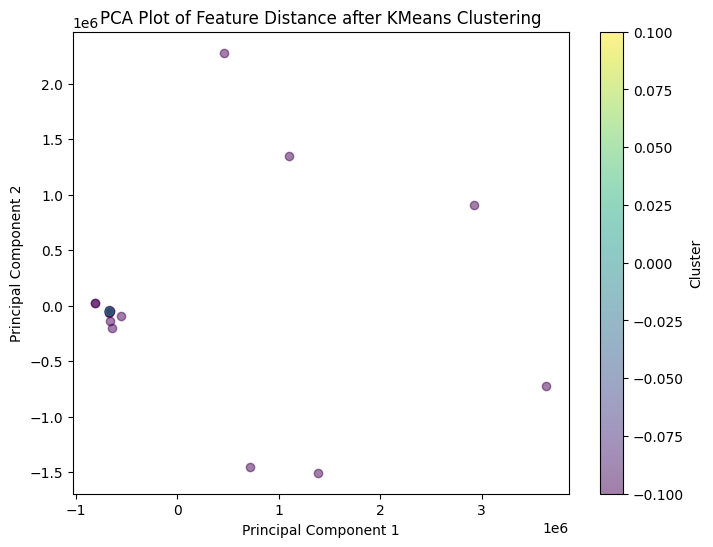

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Read the CSV file and convert the data to DataFrame
data = pd.read_csv('data/HRSS/HRSS.csv').to_numpy()

# Transpose the feature matrix
transposed_data = data.transpose()

# Use KMeans to cluster the transposed data
kmeans = KMeans(n_clusters=3)  # Specify the number of clusters
kmeans.fit(transposed_data)  # Cluster the data

# Get the cluster labels for each feature
clusters = kmeans.labels_

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_features = pca.fit_transform(transposed_data)

# Plot the clusters
plt.figure(figsize=(8, 6))

# Plot points with color corresponding to cluster labels
for i in range(len(pca_features)):
    x, y = pca_features[i]
    cluster = clusters[i]
    plt.scatter(x, y, c=cluster, cmap='viridis', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Feature Distance after KMeans Clustering')
plt.colorbar(label='Cluster')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


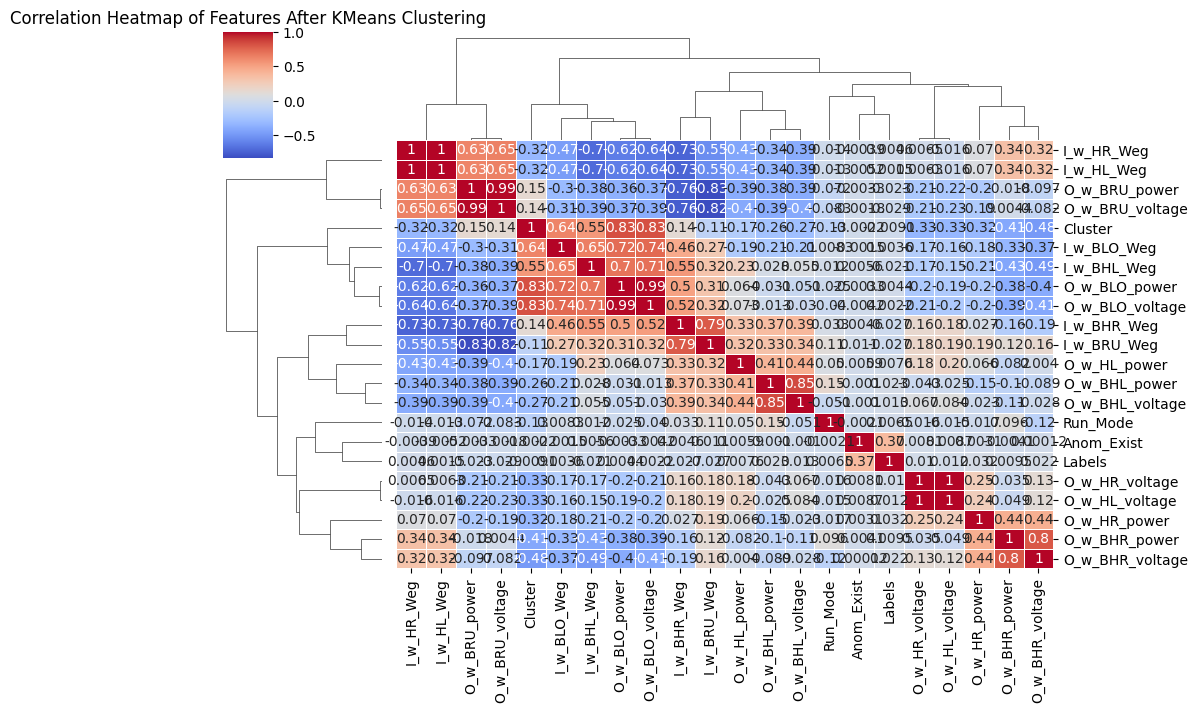

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 讀取CSV文件並將數據轉換為DataFrame
data = pd.read_csv('data/HRSS/HRSS.csv').to_numpy()

# 使用KMeans對數據進行分群
kmeans = KMeans(n_clusters=3)  # 指定要分成的群數
kmeans.fit(data)  # 對數據進行分群

# 獲取每個樣本所屬的群
clusters = kmeans.labels_

# 將分群結果添加到原始數據中
data['Cluster'] = clusters

# 繪製特徵之間的熱圖
sns.clustermap(data.corr(), cmap='coolwarm', figsize=(10, 7), linewidths=0.5, annot=True)
plt.title('Correlation Heatmap of Features After KMeans Clustering')
plt.show()

